## Installing PySpark on Google Colab instance

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 54.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=de50a4ab397fb8353b8c53f8fb568f99bb6197c14107fe941a8f71512df00984
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


## Mounting Google Drive to Colab instance

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing necessary PySpark libraries

In [3]:
#spark modules
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from time import time

#PySpark ML modules
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

#Numpy and Matplotlib modules to plot curves
import matplotlib.pyplot as plt
import numpy as np

## Creating Spark session

In [4]:
spark = SparkSession.builder\
                    .appName('loan_default_prediction_DE_OW')\
                    .getOrCreate()

## Defining the schema for the input data

In [5]:
schema = StructType(
    [
        StructField("FDICCert", IntegerType()),
        StructField("Snapshotdate", StringType()),
        StructField("PeriodDate", StringType()),
        StructField("Period", StringType()),
        StructField("foliolossrate", DoubleType()),
        StructField("TotalAssets", DoubleType()),
        StructField("folioloan", DoubleType()),
        StructField("State", StringType()),
        StructField("Quarter_Period", IntegerType()),
        StructField("Year_Period", IntegerType()),
        StructField("MacroMergeKey", StringType()),
        StructField("foliolossrateLag1", DoubleType()),
        StructField("foliolossrateLag2", DoubleType()),
        StructField("foliolossrateLag3", DoubleType()),
        StructField("foliolossrateLag4", DoubleType()),
        StructField("unemployment", DoubleType()),
        StructField("unemployment_lag1", DoubleType()),
        StructField("unemployment_lag6", DoubleType()),
        StructField("unemployment_lag8", DoubleType()),
        StructField("unemployment_lag2growth", DoubleType()),
        StructField("house_prices_all_change", DoubleType()),
        StructField("house_purchase_prices_growth", DoubleType()),
        StructField("house_purchase_prices", DoubleType()),
        StructField("house_prices_all", DoubleType()),
        StructField("CommercialPriceNat", DoubleType()),
        StructField("CommercialPriceNat_lag8", DoubleType()),
        StructField("nominal_gdp_lag8", DoubleType()),
        StructField("nominal_personalincome_lag5change", DoubleType()),
        StructField("real_disposableincome_lag3change", DoubleType()),
        StructField("real_gdp", DoubleType()),
        StructField("RepDate", StringType()),
        StructField("MovingAverage", DoubleType()),
        StructField("Target", IntegerType()),
        StructField("P1", IntegerType()),
        StructField("P10", IntegerType()),
        StructField("P11", IntegerType()),
        StructField("P12", IntegerType()),
        StructField("P2", IntegerType()),
        StructField("P3", IntegerType()),
        StructField("P4", IntegerType()),
        StructField("P5", IntegerType()),
        StructField("P6", IntegerType()),
        StructField("P7", IntegerType()),
        StructField("P8", IntegerType()),
        StructField("P9", IntegerType())
    ]
)

## File Read and Exploration

The following 4 code cells are responsible for reading the input data into a spark dataframe and performing some exploration on the same.

In [6]:
input_df = spark.read.csv('/content/drive/MyDrive/DE OW Case Study/data.txt',
                            sep='\t',
                            header=True,
                            schema=schema)

In [7]:
input_df.printSchema()

root
 |-- FDICCert: integer (nullable = true)
 |-- Snapshotdate: string (nullable = true)
 |-- PeriodDate: string (nullable = true)
 |-- Period: string (nullable = true)
 |-- foliolossrate: double (nullable = true)
 |-- TotalAssets: double (nullable = true)
 |-- folioloan: double (nullable = true)
 |-- State: string (nullable = true)
 |-- Quarter_Period: integer (nullable = true)
 |-- Year_Period: integer (nullable = true)
 |-- MacroMergeKey: string (nullable = true)
 |-- foliolossrateLag1: double (nullable = true)
 |-- foliolossrateLag2: double (nullable = true)
 |-- foliolossrateLag3: double (nullable = true)
 |-- foliolossrateLag4: double (nullable = true)
 |-- unemployment: double (nullable = true)
 |-- unemployment_lag1: double (nullable = true)
 |-- unemployment_lag6: double (nullable = true)
 |-- unemployment_lag8: double (nullable = true)
 |-- unemployment_lag2growth: double (nullable = true)
 |-- house_prices_all_change: double (nullable = true)
 |-- house_purchase_prices_grow

In [8]:
input_df.show(truncate=False)

+--------+------------+----------+------+-------------+-----------+---------+-----+--------------+-----------+-------------+-----------------+-----------------+-----------------+-----------------+------------+-----------------+-----------------+-----------------+-----------------------+-----------------------+----------------------------+---------------------+----------------+------------------+-----------------------+----------------+---------------------------------+--------------------------------+-----------+----------+-------------+------+---+---+---+---+---+---+---+---+---+---+---+---+
|FDICCert|Snapshotdate|PeriodDate|Period|foliolossrate|TotalAssets|folioloan|State|Quarter_Period|Year_Period|MacroMergeKey|foliolossrateLag1|foliolossrateLag2|foliolossrateLag3|foliolossrateLag4|unemployment|unemployment_lag1|unemployment_lag6|unemployment_lag8|unemployment_lag2growth|house_prices_all_change|house_purchase_prices_growth|house_purchase_prices|house_prices_all|CommercialPriceNat|Com

In [9]:
input_df.summary().show(truncate=False)

+-------+------------------+------------+----------+------+--------------------+------------------+------------------+------+------------------+------------------+-------------+---------------------+--------------------+--------------------+---------------------+------------------+-----------------+------------------+------------------+-----------------------+-----------------------+----------------------------+---------------------+------------------+------------------+-----------------------+------------------+---------------------------------+--------------------------------+-----------------+----------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|summary|FDICCert          |Snapshotdate|PeriodDate|Period|foliolossrate       |TotalAssets       |foli

In [10]:
categoricalColumns = ['FDICCert', 'Snapshotdate', 'PeriodDate', 'Period', 'State', 'Quarter_Period', 'Year_Period', 'MacroMergeKey', 'RepDate']
numericCols = [col for col in input_df.columns if col not in categoricalColumns and col!='Target']
# feature_columns = input_df.columns-categoricalColumns
print(numericCols)

['foliolossrate', 'TotalAssets', 'folioloan', 'foliolossrateLag1', 'foliolossrateLag2', 'foliolossrateLag3', 'foliolossrateLag4', 'unemployment', 'unemployment_lag1', 'unemployment_lag6', 'unemployment_lag8', 'unemployment_lag2growth', 'house_prices_all_change', 'house_purchase_prices_growth', 'house_purchase_prices', 'house_prices_all', 'CommercialPriceNat', 'CommercialPriceNat_lag8', 'nominal_gdp_lag8', 'nominal_personalincome_lag5change', 'real_disposableincome_lag3change', 'real_gdp', 'MovingAverage', 'P1', 'P10', 'P11', 'P12', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']


## Stage creation

In order to feed the input dataset to the ML pipeline, we need to break the entire flow into Stages and add them to the ML pipeline. The cell below is building 3 stages, described below

1. Encode the categorical columns into binary vectors using the One Hot Encoder methodology
2. Create the 'label' index using the existing 'Target' field. The predictions will be populated in this label and will also be used to evaluate the model's accuracy
3. Convert the numerical columns into binary vectors and append with categorical column vectors. This is in preparation to build the 'features' vector which will be fed to the model in order to generate predictions

In [11]:
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'Target', outputCol = 'label')
stages += [label_stringIdx]

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

## Pipeline Creation

This step builds the ML pipeline. This pipeline fits the input dataframe and generates the label and feature vectors

In [12]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(input_df)
df = pipelineModel.transform(input_df)
selectedCols = ['label', 'features']
df = df.select(selectedCols)
# df.printSchema()

## Splitting dataset

Splitting the data into 2 chunks - train and test. The train data will be used to train the model and the test data will be used to evaluate the model's accuracy and performance

In [13]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 86411
Test Dataset Count: 37093


## Model \#1 - Decision Tree Classifier

Since the objective with this case study is to classify loans as 'bad/defaulted' vs 'good/not-defaulted', I'm choosing the Decision Tree classifier model. The code cell below initializes a Decision Tree model, trains the model using the 'train' dataset and then finally generates predictions using the 'test' column

In [14]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)

In [15]:
predictions = dtModel.transform(test)
predictions.show(10,truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+-----------+----------+
|label|features                                                                                                                                                                                                                                                                                                                                           |rawPrediction|probability|prediction|
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Evaluation and Explanation

The code cell below evaluates the performance of the model prediction. The accuracy, calculated using the area under the ROC, comes out to be 100%. The accuracy does seem unusually high but there is a potential explanation behind this. While exploring the input dataset, it was observed that the 'foliolossrate' field has a complete 1:1 mapping with the 'Target'. The Target has 0 as value where the foliolossrate is 0 and if the foliolossrate is above 0, the Target is 1. The model understood this and identified this as a strong correlation and generated predictions accordingly, leading to the high accuracy.

In [16]:
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

print(f"Area under ROC curve: {bcEvaluator.evaluate(predictions)}")

mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")

print(f"Accuracy: {mcEvaluator.evaluate(predictions)}")

Area under ROC curve: 1.0
Accuracy: 1.0


In [17]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


The step below saves the trained model at a persistent disk storage (in this case it's my google drive location mounted on my Colab instance)

In [18]:
dtModel.save('/content/drive/MyDrive/DE OW Case Study/dtModel')

## Model \#2 Logistic Regression

In [19]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=30)
lrModel = lr.fit(train)

In [20]:
lrPredictions = lrModel.transform(test)
lrPredictions.show(10,False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------+-----------------------------------------+----------+
|label|features                                                                                                                                                                                                                                                                                                                                           |rawPrediction                           |probability                              |prediction|
+-----+-------------------------------------------------------------------------------------------------------------

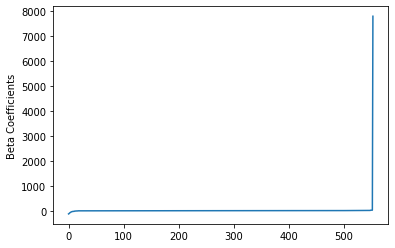

In [21]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


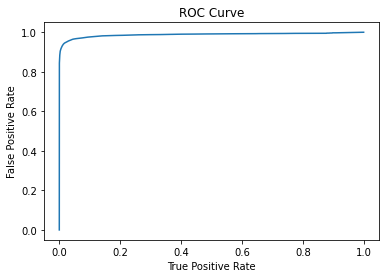

Training set areaUnderROC: 0.987783345164836


In [22]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


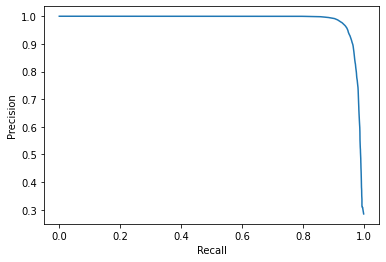

In [23]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [24]:
lrModel.save('/content/drive/MyDrive/DE OW Case Study/lrModel')